The goal of this notebook is to build and evaluate a model to predict the sex using proposed dataset.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [172]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### data input function

In [111]:
def input_fn(csv_data, is_training=False):
    """
    process the input data to deliver to the model. The same process that is done in data analysis notebook.

    args:
        csv_data: path to csv with the data to predict
        is_training: If the input data is to train the model, the difference is that the table has a 'sex' column as target
    
    return:
        Pandas DataFrame with the rows processed and ready to input in the machine learning model
    """

    df_data = pd.read_csv(csv_data, index_col='index')

    #cleaning
    df_data.drop(['slope', 'cp'], axis=1, inplace=True)
    df_data.dropna(inplace=True)
    if is_training:
        df_data.sex.replace('m', 'M', inplace=True)
        df_data.sex.replace('f', 'F', inplace=True)
        df_data.sex = df_data.sex.astype(str, errors='ignore')

    data_types = {
        'age': int,
        'trestbps': int,
        'chol': float,
        'fbs': int,
        'restecg': int,
        'thalach': int,
        'exang': int,
        'oldpeak': float,
        'ca': int,
        'thal': int,
        'nar': int,
        'hc': int,
        'sk': int,
        'trf': float
    }
    df_data = df_data.astype(data_types, errors='ignore')

    norm_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca',  'nar', 'hc', 'sk', 'trf']

    categorical_data = {'restecg':[0,1,2], 'thal':[0,1,2,3]}
    df_data.reset_index(inplace=True)
    for k,v in categorical_data.items():
        cat = pd.Categorical(df_data[k], categories = v)
        df_data = pd.concat([df_data, pd.get_dummies(cat, prefix=k)], axis=1)
        df_data.drop(k, axis=1, inplace=True)
    df_data[norm_cols] = (df_data[norm_cols]-df_data[norm_cols].mean())/df_data[norm_cols].std()
    df_data.set_index('index',inplace=True)
    return df_data

In [185]:
base_path = 'MyDrive/Colab Notebooks/sex_predictor/'
data_path = base_path+'test_data_CANDIDATE.csv'
input_data = input_fn(data_path, True)

### training and evaluating some classifiers

- random forest
- SVM

In [162]:
def rf_classifier(input_data):
    rf = RandomForestClassifier(n_estimators=110)
    scores = cross_validate(rf,
                            input_data.drop(['sex'],axis=1),
                            input_data['sex'],
                            cv=10,
                            scoring=['accuracy','f1_macro'])

    df_rf = pd.DataFrame(scores)
    return df_rf

In [171]:
df_rf = rf_classifier(input_data)
df_rf[['test_accuracy', 'test_f1_macro']].describe()

test_accuracy  test_f1_macro
count      10.000000      10.000000
mean        0.735714       0.682401
std         0.080852       0.099801
min         0.607143       0.517857
25%         0.703704       0.614286
50%         0.726852       0.687241
75%         0.805556       0.760311
max         0.851852       0.822368

I first view of the model we can see that is classifying not so bad but we can try to improve it. The random forest classifier offers the information about the features importance, we can use it to drop some bad feature.

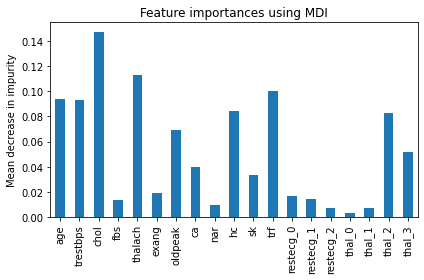

In [156]:
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(input_data.drop('sex', axis=1), input_data['sex'])
feature_names = input_data.drop('sex', axis=1).columns

importances = rf_classifier.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Based on the graphic, some features is very little relevant to the model classification, we can try drop it and run the experiments again

In [166]:
df_rf = rf_classifier(input_data.drop(['nar', 'fbs'], axis=1))
df_rf[['test_accuracy', 'test_f1_macro']].describe()

test_accuracy  test_f1_macro
count      10.000000      10.000000
mean        0.757937       0.714316
std         0.084564       0.098088
min         0.607143       0.580952
25%         0.703704       0.629945
50%         0.745370       0.698778
75%         0.814815       0.781338
max         0.888889       0.871224

Dropping This model will be considered the best one in random forest model, in essence the improvement in the mean of the model scores was almost 2% is a good improvement for a machine learning model but the score at all is low yet.

But considering this best model we can look this table, mainly in f1-score metric that shows a good balancing of true positives and true negatives.

The accuracy is a little high because the dataset has unbalanced data this is the cause of a considerable difference among this scores.

#### SVM


without prolonging too much, svm was worst than random forest in terms of metrics.

The metrics are little for a rigorous evaluation but we can have an overview of the model performances.

In [182]:
def svm_classifier(input_data):

    svm = SVC(kernel='rbf')
    scores = cross_validate(svm,
                            input_data.drop(['sex'],axis=1),
                            input_data['sex'],
                            cv=10,
                            scoring=['accuracy','f1_macro'])

    df_svm = pd.DataFrame(scores)
    return df_svm

In [192]:
df_svm = svm_classifier(input_data.drop(['nar', 'fbs'], axis=1))
df_svm[['test_accuracy', 'test_f1_macro']].describe()

test_accuracy  test_f1_macro
count      10.000000      10.000000
mean        0.728307       0.660242
std         0.068033       0.102717
min         0.629630       0.517857
25%         0.678571       0.569418
50%         0.740741       0.682906
75%         0.768519       0.725045
max         0.851852       0.822368

### Model exportation


Random forest is a good classifier, is espected a good performance, in this case better than SVM. 

Based on this metrics and numbers, random forest will be exported to create a predictor.

In [189]:
from joblib import dump
rf = RandomForestClassifier(n_estimators=110)
rf.fit(input_data.drop(['sex','nar', 'fbs'], axis=1), input_data['sex'])
dump(rf, base_path+'sex_predictor.joblib')

['MyDrive/Colab Notebooks/sex_predictor/sex_predictor.joblib']